In [149]:
import sklearn.metrics
%run 'Setup.py'

8 different classes: Electronic, Experimental, Folk, Hip-Hop, Instrumental, International, Pop or Rock.
objective 1: construct a classifier which, based on the features of a song, predicts its genre
objective 2: estimate its generalisation error under the 0–1 loss.
Features are real-valued, correspond to summary statistics (mean, sd, skewness, kurtosis, median, min, max) of 
time series of various music features, such as the chromagram or the Mel-frequency cepstrum.
Feature description: 

Feature description: 
chroma_cens: Chroma Energy Normalized (CENS, 12 chroma) - 84 features
chroma_cqt: Constant-Q chromagram (12 chroma) - 84 features
chroma_stft: Chromagram (12 chroma) - 84 features
mfcc: Mel-frequency cepstrum (20 coefficients) - 140 features
rmse: Root-mean-square - 7 features
spectral_bandwidth: Spectral bandwidth - 7 features
spectral_centroid: Spectral centroid - 7 features
spectral_contrast: Spectral contrast (7 frequency bands) - 49 features
spectral_rolloff: Roll-off freque

In [ ]:
def create_feature_element_scatter(x_train, y_train, feature_x, element_x, feature_y, element_y, statistic,genre_column='Genre'):
    """
    Creates a scatter plot comparing two features at specified elements, colored by genre.

    Parameters:
    - x_train (pd.DataFrame): DataFrame containing the feature data.
    - y_train (pd.DataFrame): DataFrame containing the genre data.
    - feature_x (str): The name of the feature for the x-axis.
    - element_x (int): The element number for the x-axis feature.
    - feature_y (str): The name of the feature for the y-axis.
    - element_y (int): The element number for the y-axis feature.
    - genre_column (str): The column name in y_train that contains genre labels.

    The function assumes the column naming convention "{feature}.{statistic}.{element}".
    """
    # Merge y_train for genre information
    x_train_with_genre = x_train.merge(y_train, left_index=True, right_on='Id')

    # Construct column names based on inputs
    column_x = f"{feature_x}_{statistic}_{str(element_x).zfill(2)}"
    column_y = f"{feature_y}_{statistic}_{str(element_y).zfill(2)}"

    # Check if the specified columns exist in the DataFrame
    if column_x not in x_train_with_genre.columns or column_y not in x_train_with_genre.columns:
        print(f"Columns {column_x} or {column_y} not found in the dataset.")
        return

    # Create the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
    sns.scatterplot(x=x_train_with_genre[column_x], y=x_train_with_genre[column_y],
                    hue=x_train_with_genre[genre_column], ax=ax, s=30, palette='rainbow')
    ax.set_title(f"{feature_y} STD vs {feature_x} STD on {element_x}th element")
    # Adjust limits if needed, or remove for automatic scaling
    ax.set(ylim=(0, 10))
    ax.set(xlim=(0, 15))
    fig.tight_layout()
    plt.show()

In [ ]:
create_feature_element_scatter(x_train, y_train, 'chroma_cens', 1, 'chroma_cens', 2, statistic='kurtosis')

# Simple Test Split (80/20)

In [150]:
X = x_train
y= y_train

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=1, shuffle = True)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, y='Genre')
plt.title('Distribution of Genres in the Y_train Dataset')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# PCA

In [ ]:
train_data_with_labels = x_train.join(y_train)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_data_with_labels.iloc[:, :-1])   identifier

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

# Apply PCA to retain 80% of the variance
pca_80 = PCA(n_components=0.8)
X_pca_80 = pca_80.fit_transform(X_scaled)
print(X_pca_80)

# Multi Class Logistic Regression

In [ ]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=42)
log_reg.fit(X_train, y_train.values.ravel())
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

In [ ]:
log_reg_cv = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)

scores = cross_val_score(log_reg_cv, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

In [ ]:
model_logreg = LogisticRegression(max_iter=500,random_state= 1, penalty='none')
model_logreg.fit(X_train, y_train)

In [ ]:
cv_score = cross_val_score(model_logreg, X_train, y_train, cv = 5)

In [ ]:
print("mean CV Score:",round(cv_score.mean(),3))
print("Train score:", round(model_logreg.score(X_train, y_train),3))
print("Test score:", round(model_logreg.score(X_test, y_test),3))

## Elastic Net (very poor)

In [ ]:
model_LgR = LogisticRegression(max_iter=200, random_state= 1)
params = {'C': [0.001],
          'l1_ratio' : [1],
          'penalty': ['elasticnet'],
          'solver': ['saga']}

gs = GridSearchCV(estimator= model_LgR, param_grid= params,  cv= 5,scoring='accuracy',n_jobs = -1, verbose=3)
gs.fit(X_train, y_train)

In [ ]:
best_LgR = gs.best_estimator_
print("Best estimator :", gs.best_estimator_.get_params())
print("Train score:", round(best_LgR.score(X_train, y_train),4))
print("Test score:", round(best_LgR.score(X_test, y_test),4))
print("Best CV score :", gs.best_score_)

# Decision Tree

In [ ]:
model_decTree = DecisionTreeClassifier(criterion='gini', max_features=1.0, max_depth= 30, random_state=1)
model_decTree.fit(X_train, y_train)
cv_score = cross_val_score(model_decTree, X_train, y_train)

In [ ]:
print("Mean CV Score:",round(cv_score.mean(),4))
print("Train score:", round(model_decTree.score(X_train, y_train),3))
print("Test score:", round(model_decTree.score(X_test, y_test),3))

# Random Forest

In [ ]:
model_RF = RandomForestClassifier(n_estimators=200 ,criterion='gini', max_features='auto', max_depth= 30, random_state=1, verbose =2)
model_RF.fit(X_train, y_train)
cv_score = cross_val_score(model_RF, X_train, y_train, cv = 5)

In [ ]:
print("CV scores:", cv_score)
print("Mean CV Score:",round(cv_score.mean(),4))
print("Train score:", round(model_RF.score(X_train, y_train),3))
print("Test score:", round(model_RF.score(X_test, y_test),3))

In [ ]:
feat_imp = pd.DataFrame(list(zip(X.columns, model_RF.feature_importances_)), columns=['feature','feat_importance']).sort_values(by='feat_importance', ascending=False)
feat_imp_top20 = feat_imp.head(20)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

sns.barplot(x = feat_imp_top20.feat_importance, y = feat_imp_top20.feature, orient='h', ax=ax, palette = 'viridis')
ax.set_title('Top 20 Feature Importance')
ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importance')
fig.tight_layout()
plt.show()

## Bagged Random Forest

In [156]:
base_rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_features='auto', max_depth=30, random_state=1, verbose=2)
model_RF_bagged = BaggingClassifier(base_estimator=base_rf, n_estimators=10, random_state=1, verbose=2)
model_RF_bagged.fit(X_train, y_train.values.ravel())
cv_score = cross_val_score(model_RF_bagged, X_train, y_train.values.ravel(), cv=5)


/Users/max/anaconda3/envs/pythonProject/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/max/anaconda3/envs/pythonProject/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.2s finished
/Users/max/anaconda3/envs/pythonProject/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.3s finished
/Users/max/anaconda3/envs/pythonProject/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

KeyboardInterrupt: 

In [ ]:
print("CV scores:", cv_score)
print("Mean CV Score:",round(cv_score.mean(),4))
print("Train score:", round(model_RF_bagged.score(X_train, y_train),3))
print("Test score:", round(model_RF_bagged.score(X_test, y_test),3))

# More Cross Validation

### Grid Search

Careful, heavy compute!

In [ ]:
model_RF = RandomForestClassifier(criterion='gini', max_features='auto', max_depth= 30, random_state=1, verbose =2)

params = {'n_estimators': [200],
          'max_features' : [0.3, 0.5, 0.8, 1],
          'max_depth': [10, 30, 60, None]}

gs = GridSearchCV(estimator= model_RF, param_grid= params,  cv= 5,scoring='accuracy',n_jobs = -1, verbose=3)
gs.fit(X_train, y_train)

In [152]:
best_RF = gs.best_estimator_

print("Best estimator :", gs.best_estimator_.get_params())
print("Train score:", round(best_RF.score(X_train, y_train),4))
print("Test score:", round(best_RF.score(X_test, y_test),4))
print("Best CV score :", gs.best_score_)



Best estimator : {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 0.3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 2, 'warm_start': False}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Train score: 1.0
Test score: 0.5494
Best CV score : 0.5502380952380953


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


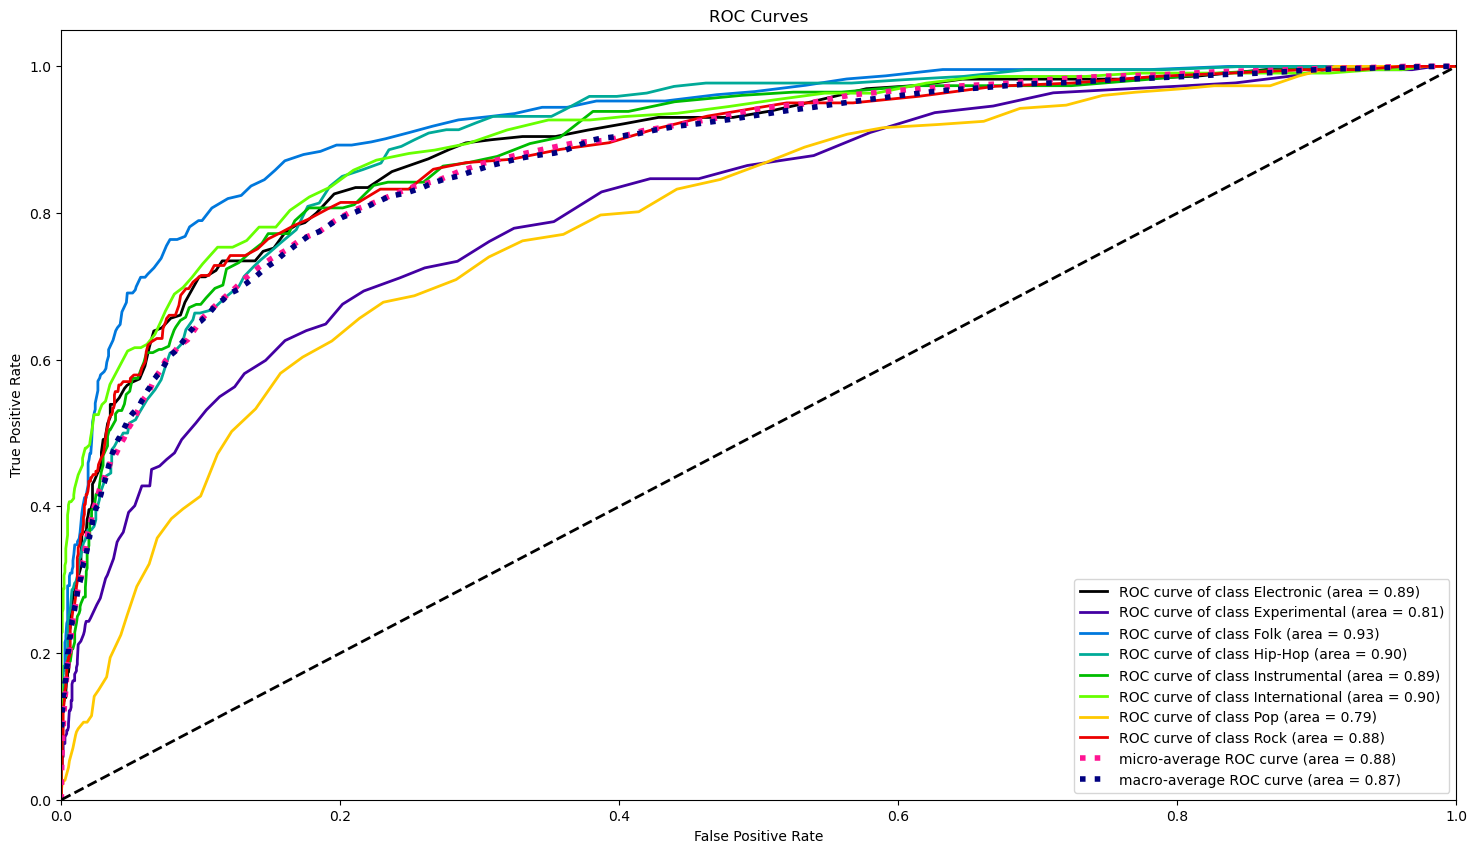

In [154]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,10))
skplt.metrics.plot_roc(y_test, best_RF.predict_proba(X_test), ax=ax)
plt.show()


## Random Search

Careful, heavy compute!


In [ ]:
rf = RandomForestClassifier(random_state=42)
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 40),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train.values.ravel())

In [ ]:
print("Best parameters found (Random Search): ", random_search.best_params_)
print("Best accuracy found (Random Search): ", random_search.best_score_)

# Ada Boost

## Base Decision Tree

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=5, max_features=0.3)
model_AB = AdaBoostClassifier(estimator = base_estimator, n_estimators = 100, random_state=1)
model_AB.fit(X_train, y_train)
cv_score = cross_val_score(model_AB, X_train, y_train, cv = 5)

In [ ]:
print("Mean CV Score:",round(cv_score.mean(),4))
print("Train score:", round(model_AB.score(X_train, y_train),3))
print("Test score:", round(model_AB.score(X_test, y_test),3))

## Base Logistic Regression

In [ ]:
base_estimator = LogisticRegression(max_iter=10000,random_state= 1, penalty='l2', verbose = 2)
model_AB = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = 200, random_state=1)
model_AB.fit(X_train, y_train)
cv_score = cross_val_score(model_AB, X_train, y_train, cv = 5)

In [ ]:
print("Mean CV Score:",round(cv_score.mean(),4))
print("Train score:", round(model_AB.score(X_train, y_train),3))
print("Test score:", round(model_AB.score(X_test, y_test),3))

In [ ]:
%run 'Setup.py'